# Machine Translation

English-German Translation

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 


Using TensorFlow backend.


# 2)- Reading Dataset

In [0]:
df= pd.read_pickle('full_data_clean.pkl')

In [42]:
df.shape

(22191, 2)

In [0]:
df_random=df.sample(5000)

In [44]:
df_random.head(15)

,eng,ger
13353,the scale includes questions like many things i have to do are repetitive and monotonous and i have so many interests i dont have time to do everything,auf der skala finden sich aussagen wie viele dinge die ich tun muss wiederholen sich und sind monoton und ich habe so viele interessen dass ich nicht genug zeit fur alles habe
1566,the performance of treasury bond fell to against on friday evening and the bond to against on the previous day,die einnahmen der staatskasse innerhalb von zehn jahren sind freitag abend von auf zuruckgegangen und die einnahmen innerhalb von jahren gestern abend von auf
19122,peskov said putins reference to statehood was meant in the context of the broader autonomy that has been discussed for months with the kiev leadership as it struggles to allay fears in the russian...,peskow sagte dass putins verweis auf die staatlichkeit im kontext mit der groeren autonomie gesehen werden musse die seit monaten von der kiewer fuhrung diskutiert wird um befurchtungen in russisc...
20693,the handballers of rheinneckar lowen are being challenged this evening pm at bergischer hc,die handballer der rheinneckar lowen sind heute abend uhr beim bergischen hc gefordert
872,previously the commission said that bskybs stake thwarted competition and allowed it unfair influence over itv,zuvor hatte die kommission behauptet der anteil bskybs verzerre den wettbewerb und ermogliche ihm einen unlauteren einfluss auf den sender itv
8623,he then promised that his arrival to the head of the football would not mean any personnel housecleaning,damals versprach er auch dass sein einzug in die spitze des tschechischen fuballs keine personellen sauberungen bedeuten werde
15435,with this opinion she is at least not alone in the state capital,mit dieser meinung steht sie zumindest in der landeshauptstadt nicht allein da
12205,how many of those were present at the beginning in,wie viele davon waren von anfang an dh seit dabei
20020,following the strike which was halted on legal grounds negotiations with the pilots union cockpit vc in the pay dispute will be resumed on thursday,im tarifkonflikt mit der pilotenvereinigung cockpit vc sollen die verhandlungen nach dem gerichtlich gestoppten streik an diesem donnerstag wieder aufgenommen werden
525,since the acquisition of depfa hypo real estate has been a significant financer of government and infrastructure,die hypo real estate ist seit der depfaubernahme ein bedeutender staats und infrastrukturfinanzierer


In [0]:
deu_eng=df_random.values

In [46]:
type(deu_eng)

numpy.ndarray

In [47]:
deu_eng[0]

array(['the scale includes questions like many things i have to do are repetitive and monotonous and i have so many interests i dont have time to do everything',
       'auf der skala finden sich aussagen wie viele dinge die ich tun muss wiederholen sich und sind monoton und ich habe so viele interessen dass ich nicht genug zeit fur alles habe'],
      dtype=object)

In [48]:
# for english part 
deu_eng[:,0]

array(['the scale includes questions like many things i have to do are repetitive and monotonous and i have so many interests i dont have time to do everything',
       'the performance of treasury bond fell to against on friday evening and the bond to against on the previous day',
       'peskov said putins reference to statehood was meant in the context of the broader autonomy that has been discussed for months with the kiev leadership as it struggles to allay fears in the russianspeaking areas that their cultural and linguistic rights are in danger',
       ...,
       'the suit seeks unspecified damages but the familys lawyer sam davis said he took the case for free and that the family plans to donate any money it gets to a childrens cancer charity',
       'nancy pelosi chairwoman of the house of representatives provided the information that the house of representatives was expected to vote on the bill on monday',
       'the england head coach trevor bayliss praised his attitude 

In [49]:
# for german part of lang.
deu_eng[:,1]

array(['auf der skala finden sich aussagen wie viele dinge die ich tun muss wiederholen sich und sind monoton und ich habe so viele interessen dass ich nicht genug zeit fur alles habe',
       'die einnahmen der staatskasse innerhalb von zehn jahren sind freitag abend von auf zuruckgegangen und die einnahmen innerhalb von jahren gestern abend von auf',
       'peskow sagte dass putins verweis auf die staatlichkeit im kontext mit der groeren autonomie gesehen werden musse die seit monaten von der kiewer fuhrung diskutiert wird um befurchtungen in russischsprachigen gebieten zu zerstreuen dass deren kulturelle und sprachliche rechte gefahrdet seien',
       ...,
       'die klage lautet auf einen nicht naher bestimmten schadensersatz doch der anwalt der familie sam davis sagte dass er kein honorar in rechnung stelle und die familie plane das geld das sie bekomme der kinderkrebshilfe spenden wird',
       'am sonntag teilte die sprecherin des reprasentantenhauses nancy pelosi mit dass das

# 3)-Text Pre-Processing

### 3.1)-Text cleaning

In [0]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]] 
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]] 

# convert text to lowercase 
for i in range(len(deu_eng)): 
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

### 3.2)-Text to Sequence Conversion

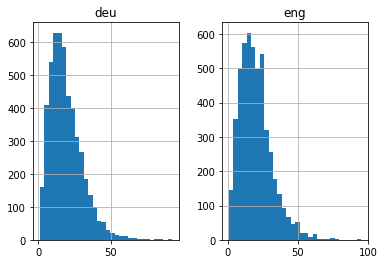

In [51]:
# empty lists 
eng_l = [] 
deu_l = [] 

# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
      eng_l.append(len(i.split())) 

for i in deu_eng[:,1]: 
      deu_l.append(len(i.split())) 

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30) 
plt.show()

the maximum length of the German sentences is 78 and that of the English phrases is 75.

### 3.3)-vectorize our text data 

by using Keras’s Tokenizer()

In [52]:
# function to build a tokenizer 
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 8 

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 14142


In [53]:
# prepare Deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[:, 1]) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 8 
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 20761


There is difference in amount of words in two languages.We need to encode sequence

### 3.4)-encode and pad sequences 

In [0]:
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

# 4)-Model Building

### 4.1)- Train-test Split

80%-20%

In [0]:
from sklearn.model_selection import train_test_split 

# split data into train and test set 
train,test= train_test_split(deu_eng,test_size=0.2,random_state= 12)

### 4.2)- Defining input and target
We will encode English sentences as the input sequences and German sentences as the target sequences

In [56]:
# english version
train[:, 0]

array(['several people who went through the site noted that in the countryhouse whose wall is beige with brown the gate was wide open',
       'get some of the words in your mouth and then youll understand why we all love shakespeare so much',
       'eight wa winners have celebrated division one wins last month capping off a lucky few weeks for the states players',
       ...,
       'an industry which has cost quebec taxpayers dearly especially in the and',
       'francisco catunda the charge daffaires of the brazilian embassy in the honduran capital told tv globo that mel knows that he must leave the embassywhere he has been a refugee since september before that date',
       'georgy does not like to look at this picture and it is hidden it in the bookcase in our home'],
      dtype=object)

In [57]:
# english version
train[:, 1]

array(['mehrere vorubergehende sahen dass die tur des von einer beigebraunen mauer umgebenen landhauses sperrangelweit aufstand',
       'nimm ein paar der worte in den mund und dann wirst du verstehen warum wir alle shakespeare so lieben',
       'acht wagewinner haben im vergangenen monat gewinne in der ersten division gefeiert ein gebuhrender abschluss fur ein paar gluckliche wochen fur die spieler im staat',
       ...,
       'eine industrie die fur den steuerzahler quebecs sehr teuer war insbesondere in den und jahren',
       'francisco catunda der handelsdelegierte der brasilianischen botschaft in der honduranischen hauptstadt bestatigte dem fernsehsender tv globo dass mel wei dass er vor diesem datum die botschaft in der er seit dem september asyl gefunden hatte verlassen haben muss',
       'georgij sieht das bild nicht gerne und es ist bei uns zu hause im bucherregal versteckt'],
      dtype=object)

In [0]:
# prepare training data 
trainX = encode_sequences(eng_tokenizer, deu_length, train[:, 0]) 
trainY = encode_sequences(deu_tokenizer, eng_length, train[:, 1]) 

# prepare validation data 
testX = encode_sequences(eng_tokenizer, deu_length, test[:, 0]) 
testY = encode_sequences(deu_tokenizer, eng_length, test[:, 1])

In [59]:
print(trainX[:5])

[[10958    12  2413     1  3208    13  2220   319]
 [ 1073   246    38    47   376  5776    62   144]
 [    6  3991   158   458     9     1   171   330]
 [ 1067  3369   966   260   626     1   153  2733]
 [ 4300     6   377   962  3058    12    26  1005]]


In [60]:
print(trainY[:5])

[[    5    34 14918  1674 14919 14920 14921  6496]
 [  387   768   416    48   111  5851    44  2560]
 [  327  5293   427    13     1   471    14   530]
 [ 7046   464  1114     7   658  4185     6   299]
 [   49  4010    18  4011     9    32 13797  1170]]


In [61]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(4000, 8)
(4000, 8)
(1000, 8)
(1000, 8)


### 4.3)- build NMT model

In [62]:
eng_length

8

In [63]:
deu_length

8

In [0]:
 def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, n, input_length=in_timesteps,   
      mask_zero=True)) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

In [0]:
# model compilation (with 512 hidden units)
model = build_model(eng_vocab_size,deu_vocab_size, eng_length, deu_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 8, 512)            3702272   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 8, 9284)           4762692   
Total params: 12,663,364
Trainable params: 12,663,364
Non-trainable params: 0
_________________________________________________________________


In [66]:
filename = 'model_translate.h1' 

# set checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 


# train model 
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)

Train on 3200 samples, validate on 800 samples
Epoch 1/30
3200/3200 [==============================] - 5s 2ms/step - loss: 9.1959 - val_loss: 8.1035

Epoch 00001: val_loss improved from inf to 8.10350, saving model to model_translate.h1
Epoch 2/30
3200/3200 [==============================] - 3s 913us/step - loss: 7.7073 - val_loss: 8.2315

Epoch 00002: val_loss did not improve from 8.10350
Epoch 3/30
3200/3200 [==============================] - 3s 926us/step - loss: 7.5113 - val_loss: 8.4340

Epoch 00003: val_loss did not improve from 8.10350
Epoch 4/30
3200/3200 [==============================] - 3s 922us/step - loss: 7.4654 - val_loss: 8.4304

Epoch 00004: val_loss did not improve from 8.10350
Epoch 5/30
3200/3200 [==============================] - 3s 919us/step - loss: 7.3780 - val_loss: 8.5961

Epoch 00005: val_loss did not improve from 8.10350
Epoch 6/30
3200/3200 [==============================] - 3s 912us/step - loss: 7.3818 - val_loss: 8.6059

Epoch 00006: val_loss did not impr

# 5)-Plotting results

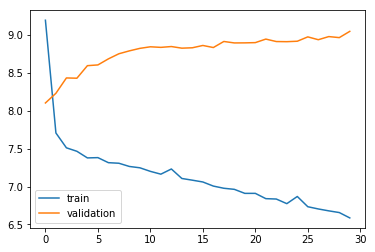

In [67]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

As you can see in the above plot, the validation loss stopped decreasing after 25 epochs. It did improve but not very significant.

# 6)-Make Predictions

In [0]:
model = load_model('model_translate.h1') 

preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

These predictions are sequences of integers. We need to convert these integers to their corresponding words.

### 6.1)- Convert integers to words

In [0]:
def get_word(n, tokenizer):  
      for word, index in tokenizer.word_index.items():                       
          if index == n: 
              return word 
      return None

### 6.2)-Convert predictions into text (German)

In [0]:
preds_text = [] 
for i in preds:        
       temp = []        
       for j in range(len(i)):             
            t = get_word(i[j], deu_tokenizer)             
            if j > 0:                 
                if (t==get_word(i[j-1],deu_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [72]:
# 1st 5 rows
pred_df.head(5)

,actual,predicted
0,der ehemalige eukommissar hatte gestern vor dem heutigen aufeinandertreffen von gewerkschaften und arbeitgeberschaft eine verhandlung mit den politischen parteien abgehalten,der
1,eine mit der situation vertraute person sagte reuters am montag die kredithilfen beliefen sich auf bis zu milliarden euro,der
2,dann ging die zeit der alten freien jedoch nicht offiziell anerkannten maler damals zu ende und neue und freie maler wie ich waren unverstandlich,der
3,wie die zeitung meldet haben bis jetzt die wiener borse die nasdaq transatlantic die new york stock exchange die londoner borse und die deutsche borse angebote gelegt,der
4,war aber die schwanzneigung vornehmlich nach links wieder aus perspektive des hundes der wedelt so stieg ihre herzfrequenz und sie sahen unruhig aus,der


In [73]:
# print 5 rows randomly 
pred_df.sample(5)

,actual,predicted
841,es sei ihm ein moralisches bedurfnis diese anmerkung zu machen,der
290,einige kameras sind nur fur bis zu fu zugelassen andere bis oder fu,der
591,die regierung gibt renamo die schuld fur die zusammenstoe und beschuldigt die organisation soldaten angegriffen zu haben,der
657,ich glaube an systematisches vorgehen und das ist etwas was mirek pelta nicht bringt,der
568,am teuerste wird es fur kunden die es selten maximal zehnmal im monat verwenden namlich euro pro monat,der
